# 🔎 폐렴을 보는 눈
이번 과제는 폐 x-ray를 input으로 폐렴 확진 여부를 판단하는 과제이다. 모델로는 CNN을 사용하였다. 한번 살펴보자.

- 데이터 : [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)
- 커널: [
TensorFlow Pneumonia Classification on X-rays](https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays)

## 🥇루브릭 기준
1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.
   - 모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.
2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.
   - regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.
   - (augmentation, regularization) : (o, o), (o, x), (x, o), (x, x)
3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.
   - Accuracy 기준 85%에 도달하였다.

# Step 1. 실험환경 Set-up

In [2]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 20

print(ROOT_PATH)

/aiffel/aiffel


# Step 2. 데이터 준비하기

In [4]:
#glob와 같은 방식으로 list를 가져온다
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)


print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


train, val 비율이 너무 적으니 8:2로 맞춘다

In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


- 정상 이미지와 폐렴 이미지를 구분(레이블)

In [6]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1521_virus_2649.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person313_bacteria_1457.jpeg


In [7]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1068
Pneumonia images count in training set: 3117


- CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 함
- 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정

- 배치처리를 효율적으로 하게 해주는 Dataset

In [8]:
train_filenames[0]

'/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1521_virus_2649.jpeg'

In [9]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

- Train 데이터셋, validation 데이터셋 개수 확인

In [10]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


- 파일 경로를 이용해서 라벨 데이터 만들어 주기

In [11]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

- 이미지 파일 : 현실적으로 사이즈가 제각각일 가능성이 높음
  - 이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여봅시다.

In [12]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train 데이터 셋과 validation 데이터 셋 만들기
  - num_parallel_calls 파라미터에서 set-up에서 초기화 한 AUTOTUNE을 이용

In [13]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [14]:
for image, label in train_ds.take(1): # Dataset에서 하나의 데이터만 가져옴
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


- Data Augmentation of Train/Val
- 의료데이터: 데이터 제약이 많으므로 Data augmentation 활용
  - 최적화된 방법을 찾기가 어렵고 제약사항이 많음
  - 기본적인 Data augmentation 방법들을 사용
    - 이미지 회전
    - 가우시간 노이즈 추가: 장기의 크기는 균등함
    - GAN을 이용한 방법

In [15]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
#     image = tf.keras.layers.GaussianNoise(0.1)
    return image,label

- test 셋 만들기

In [16]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


tf.data 파이프라인
prepare_for_training() : 학습 데이터를 효율적으로 할 수 있도록 데이터를 변환 

- `shuffle()`을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.

- `repeat()`를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 복원추출하게 해줌. 예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰줍니다.

- `batch()`를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됩니다.

- `prefetch()`를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.

- [Trouble] 여기서 좌우반전만 적용되었고, 이미지가 추가되진 않음
  - [Shooting]  concatenate을 이용해 좌우반전된 이미지를 추가해 주었다
  - [Trouble] 예상대로 작동하지 않음. 그렇다면 먼저 기존 데이터를 학습하고 좌우 반전된 데이터를 학습해볼까 ? 

In [17]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
#     ds = ds.concatenate(ds2)
    
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [18]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# Step 3. 데이터 시각화 

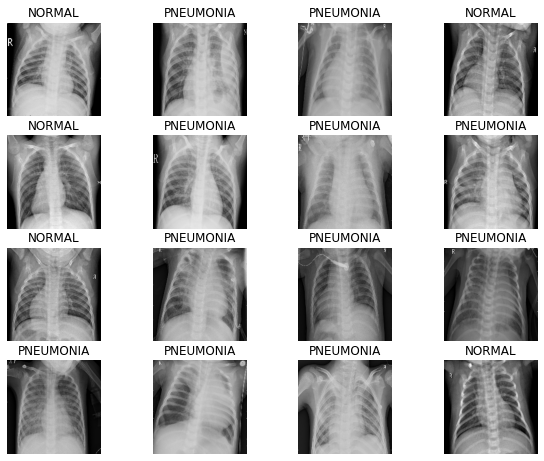

In [19]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

##  CNN 모델링

- [CNN, Convolutional Neural Network 요약](http://taewan.kim/post/cnn/) 

In [20]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [21]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
#         tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

- BN과 Dropout을 같이 쓴다고?!  
  - 미쳤구나! [Understanding the Disharmony between Dropout and Batch Normalization by Variance Shift](https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf)
     - Batch Normalization: variance shift를 억제 vs Dropout: 유발
     - 동시에 사용하는 것이 어울리지 않는다
  - ㄴㄴ 가끔은 그럴만해! [Rethinking the Usage of Batch Normalization and Dropout in the Training of Deep Neural Networks](https://arxiv.org/pdf/1905.05928.pdf)

In [22]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 데이터 imbalance 처리 
- [참고][딥러닝에서 클래스 불균형을 다루는 방법](https://3months.tistory.com/414)
- [Trouble] 한 라벨이 너무 많은 imbalance의 경우 학습 효과가 좋지 않음
- [Shooting] Weight balancing
  -  training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법
  - Keras는 model.fit(class_weight = {...}) 클래스별 가중치를 세팅

In [23]:
#weight: 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정
#'Normal' 이미지에 사용할 weight
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
#'Pneumonia' 이미지에 사용할 weight
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## 모델 훈련 of 3가지 모델
- loss : binary_cross entropy(이미지 라벨이 2개인 경우)
- optimizer : adam
- metrics:  'accuracy', 'precision', 'recall'

In [24]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

- 오버핏 방지를 위해 early stopping을 추가해주었다.

In [25]:
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

In [26]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[es]
    )

Epoch 1/20
261/261 [==============================] - 56s 140ms/step - loss: 0.5624 - accuracy: 0.6924 - precision: 0.8335 - recall: 0.7377 - val_loss: 0.7133 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 2/20
261/261 [==============================] - 35s 133ms/step - loss: 0.2674 - accuracy: 0.8766 - precision: 0.9783 - recall: 0.8536 - val_loss: 1.5065 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 3/20
261/261 [==============================] - 34s 132ms/step - loss: 0.2350 - accuracy: 0.8976 - precision: 0.9793 - recall: 0.8815 - val_loss: 0.4784 - val_accuracy: 0.7365 - val_precision: 0.7350 - val_recall: 1.0000
Epoch 4/20
261/261 [==============================] - 35s 133ms/step - loss: 0.2041 - accuracy: 0.9102 - precision: 0.9776 - recall: 0.9003 - val_loss: 0.1520 - val_accuracy: 0.9385 - val_precision: 0.9767 - val_recall: 0.9382
Epoch 5/20
261/261 [==============================] - 35s 134ms/step - loss: 0.1530 - accura

In [28]:
# MODEL1
# model.save('saved_model/GODSAVEME_DA_5,16')
# MODEL2
# model.save('saved_model/GODSAVEME_5,16')
# MODEL3
model.save('saved_model/GODSAVEME_5,16_-BN')

INFO:tensorflow:Assets written to: saved_model/GODSAVEME_5,16_-BN/assets


### 모델 간 비교 / MODEL N: ( EPOCH, BATCH_SIZE ), ETC
#### MODEL1: (5, 16), DataTransformation~~Augmentation~~(right), BN+Dropout
- Data Augmentation이 아니라 Data Transformation 이었다!

In [110]:
!ls saved_model

GODSAVEME_DA_5,16


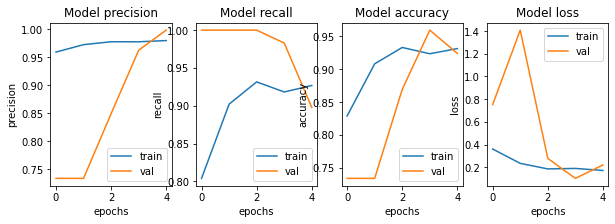

In [106]:
fig, ax = plt.subplots(1, 4, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [111]:
new_model01 = tf.keras.models.load_model('saved_model/GODSAVEME_DA_5,16')

In [112]:
loss, accuracy, precision, recall = new_model01.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 73ms/step - loss: 0.3665 - accuracy: 0.8686 - precision: 0.8649 - recall: 0.9359
Loss: 0.3665120601654053,
Accuracy: 0.8685897588729858,
Precision: 0.8649289011955261,
Recall: 0.9358974099159241


#### MODEL2: (5, 16), BN+Dropout

In [110]:
!ls saved_model

GODSAVEME_DA_5,16


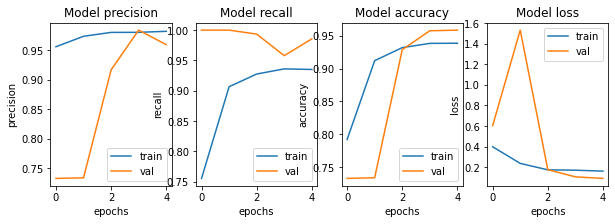

In [27]:
#위에서 모델 학습 직후에 그려둔 그림!!
fig, ax = plt.subplots(1, 4, figsize=(10, 3))
ax = ax.ravel()
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [29]:
new_model02 = tf.keras.models.load_model('saved_model/GODSAVEME_5,16')

In [30]:
loss, accuracy, precision, recall = new_model02.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 74ms/step - loss: 0.7577 - accuracy: 0.7612 - precision: 0.7252 - recall: 0.9949
Loss: 0.7577215433120728,
Accuracy: 0.7612179517745972,
Precision: 0.7252336740493774,
Recall: 0.9948717951774597


#### MODEL3: (20 with ES, 16), BN과 Dropout중 BN제거, Data Transformation

In [29]:
!ls saved_model

GODSAVEME_5,16	GODSAVEME_5,16_-BN  GODSAVEME_DA_5,16


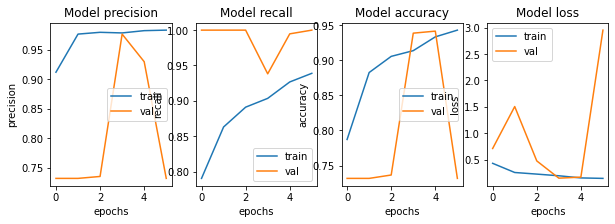

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [30]:
new_model03 = tf.keras.models.load_model('saved_model/GODSAVEME_5,16_-BN')

In [31]:
loss, accuracy, precision, recall = new_model03.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 72ms/step - loss: 6.3233 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 6.323273658752441,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


### [결론]  
- epoch, batch, 데이터증강(변환), regularization 방법을 바꿔가며 3가지 모델을 이용해 학습해보았다.
    - MODEL1: (5, 16), 데이터 변환(좌우), BN과 Drop을 동시에 사용하는 모델
    - MODEL2: (5, 16), 데이터 변환 없음, BN과 Drop을 동시에 사용하는 모델
    - MODEL3: (20 with ES, 16), 데이터 변환, BN과 Dropout중 BN제거
- 3개의 모델 중 Accuracy를 기준으로 MODEL 1 >> 2 > 3
    - 여러번의 모델 수행을 통해 더 정확한 결론을 얻을 수 있었겠지만, 얻어낸 샘플로 다음과 같은 추론을 할 수 있다.
    - 데이터를 변환하는 것이 더 모델의 정확도를 높인다. (증강으로 데이터를 추가해보지는 못했다.)
    - Batch Normalization과 Dropout을 동시에 사용하는 모델이 정확도가 더 높다.

# 회고 
- 해당 과제는 CNN을 통해 x-ray사진으로 부터 폐렴의 유무를 판단하는 과제였다.
- tensorflow에 대한 기초적인 이해가 약하고, CNN을 구현해내는 과정이 익숙하지 않아 많은 어려움을 겪었다. 이러한 과정에서 여러 자료를 참고하고, 기본적인 구현법을 익히고 난 후 코드가 보다 자연스레 읽히는 경험을 하였다.
- 그 중 layer를 쌓는 것을 여러차례 관찰하고 따라하면서 이해가 증진되었고, 학습한 model을 저장하는 기법을 얻어 개인적으로 큰 성과를 냈다고 생각한다.
- 그러나 DataSet이라는 generator에 대한 이해가 부족해 본문에서 주어진 augment코드를 이용해 Data를 변환하기만 하였을 뿐, Image Augmentation을 적절히 적용하지 못하였다. 조금 더 학습이 필요한 부분이다.
- 또 CNN이 구성되는 기초적인 동작은 이해하더라도, BN, Dropout을 동시에 사용했을 경우 생기는 교호작용을 이해하기에는 부족하였다. 긴 학습이 필요한 부분이다.
- 아직 딥러닝을 보는 실력이 블랙박스를 보는 것 같다. 머신러닝과 딥러닝 중 머신러닝에 더 무게를 싣고 공부를 하고 있지만, 딥러닝에서도 파트를 정해서 한 부분이라도 설명할 수 있는 실력을 가져야 겠다는 생각을 하였다. 이 길이 맞았으면 좋겠다.

---
## 참고자료
 - 모델의 저장과 로드: [텐서플로우 튜토리얼 save_and_load](https://www.tensorflow.org/tutorials/keras/save_and_load)
 
 - 이미지 증강
   - [Data Augmentation in Medical](https://towardsdatascience.com/data-augmentation-in-medical-images-95c774e6eaae)
   - [데이터 증강기법](https://libertegrace.tistory.com/entry/3-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%A6%9D%EA%B0%95%EA%B8%B0%EB%B2%95-Data-Augmentation)
 - 전이학습 : [소표본 의료 영상 전이학습 ](https://www.koreascience.or.kr/article/CFKO201826259815416.pdf)
 
 